# Text Classification Project: Predicting Nationality from Wikipedia Biographies

## Project Overview:

This project aims to develop a text classification model that can accurately predict a person's nationality based on their Wikipedia biography. By leveraging natural language processing techniques, we'll extract meaningful features from the text data and train a machine learning model to classify individuals into their respective nationalities.

### Imports and setup

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from IPython.display import display

# Set random seed for reproducibility
RANDOM_SEED = 655

### Part 1: Data Processing

We'll start by loading and preprocessing the data. It's essential to clean the data for further analysis.

#### Loading the data

In [7]:
nationality_df = pd.read_csv(r'C:/users/akama/downloads/wikipedia_text_classification/bio_nationality.tsv.gz', 
                             sep='\t', compression='gzip', index_col=0)

# Skip empty entries
nationality_df = nationality_df.dropna()

# Use a subset of the data to save on runtime and memory
nationality_df = nationality_df[:75000]

# Displaying a sample of data
display(nationality_df.sample(5, random_state=RANDOM_SEED))

,bio,nationality
46957,Early life and education\nDiskin was born in G...,"israelis, israeli"
39447,Biography\nMarjanović was born into a large wo...,serbian
57804,Michel Demaret (18 January 1940 - 9 November 2...,belgium
72739,"Life\n'Profile Head with Cap', woodcut on pape...",american
23793,Life\nBeddoes was born in Shifnal on 13 April ...,british


#### Inspecting Labels

In [9]:
print(nationality_df.nationality.nunique())
assert len(set(nationality_df.nationality)) == 5374

5374


We'll print out the most common labels to notice any issues:

In [10]:
display(nationality_df.nationality.value_counts().head(20))

american                   14273
british                     5522
united states, american     2968
australian                  2247
united states               1729
indian                      1524
english                     1435
americans, american         1339
canadians, canadian         1298
french                      1289
canadian                    1284
united kingdom, british     1184
german                      1104
japanese                    1038
usa                          996
italian                      927
british people, british      846
polish                       705
irish people, irish          630
irish                        561
Name: nationality, dtype: int64

#### Task 1.1: Identify Redundant Labels

Set `redundant_entries` to be a list containing labels that are redundant.

In [11]:
redundant_entries = [
    'united states, american', 'united states', 'americans, american', 
    'canadians, canadian', 'united kingdom, british'
]

#### Task 1.2: Standardize the Nationality Labels

We'll implement the following standardization:

In [12]:
def standardize_nationality(nationality):
    parts = nationality.split(',')
    standardized_label = parts[-1].strip()
    return standardized_label

nationality_df['nationality'] = nationality_df['nationality'].apply(standardize_nationality)

In [13]:
# Verify the number of standardized labels

print(len(set(nationality_df.nationality)))

3197


#### Task 1.3: Inspect Standardized Labels

Set `redundant_standardized_labels` to identify redundant labels in standardized data:

In [14]:
redundant_standardized_labels = ['united states', 'usa']

#### Task 1.4: Filter Out Infrequent Labels

Create a cleaned dataset by filtering rows with labels occurring at least 500 times:

In [15]:
MIN_NATIONALITY_COUNT = 500

cleaned_nationality_df = nationality_df[nationality_df.groupby('nationality')['nationality'].
                                        transform('count') >= MIN_NATIONALITY_COUNT]

print(len(cleaned_nationality_df), cleaned_nationality_df.nationality.nunique())

51931 19


#### Task 1.5: Create Train/Dev/Test Data Splits

Now we'll split our data into train, development, and test sets:

In [16]:
TRAIN_SIZE = .8
DEV_SIZE = .1
TEST_SIZE = .1

train_dev_df, test_df = train_test_split(
    cleaned_nationality_df, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True
)

train_proportion_in_train_dev = TRAIN_SIZE / (TRAIN_SIZE + DEV_SIZE)

train_df, dev_df = train_test_split(
    train_dev_df, test_size=(1 - train_proportion_in_train_dev), random_state=RANDOM_SEED, shuffle=True
)

print(len(train_df), len(dev_df), len(test_df))

41544 5193 5194


### Part 2: Tokenizing the Data

To use a text classifier, we need to convert text into features. We start by tokenizing it — i.e., splitting the text into words.

#### Task 2.1: Implement Various Tokenizers

We'll compare three tokenization methods:

In [17]:
def simple_split(text):
    return text.split()

def sklearn_split(text):
    token_pattern = re.compile(r'(?u)\b\w\w+\b')
    return token_pattern.findall(text)

def nltk_split(text):
    return word_tokenize(text)

In [20]:
# Process a subset of the data with each tokenizer

split_tokens = Counter()
sklearn_regex_tokens = Counter()
nltk_tokens = Counter()

wordcount_subset = train_df.head(1000)

for bio in tqdm(wordcount_subset.bio):
    bio = bio.lower()
    split_tokens.update(simple_split(bio))
    sklearn_regex_tokens.update(sklearn_split(bio))
    nltk_tokens.update(nltk_split(bio))

print('simple split:', len(split_tokens))
print('sklearn:', len(sklearn_regex_tokens))
print('nltk:', len(nltk_tokens))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 443.85it/s]

simple split: 61341
sklearn: 33501
nltk: 39102


In [22]:
# Compare token differences

split_sklearn_diff = Counter({w: c for w,c in split_tokens.items() if w not in sklearn_regex_tokens})
sklearn_split_diff = Counter({w: c for w,c in sklearn_regex_tokens.items() if w not in split_tokens})

nltk_sklearn_diff = Counter({w: c for w,c in nltk_tokens.items() if w not in sklearn_regex_tokens})
sklearn_nltk_diff = Counter({w: c for w,c in sklearn_regex_tokens.items() if w not in nltk_tokens})

print('%d tokens from split that sklearn does not output. most frequent:' % len(split_sklearn_diff))
print(split_sklearn_diff.most_common(20))
print()
print('%d tokens from sklearn that split does not output. most frequent:' % len(sklearn_split_diff))
print(sklearn_split_diff.most_common(20))
print('\n')
print('%d tokens from nltk that sklearn does not output. most frequent:'% len(nltk_sklearn_diff))
print(nltk_sklearn_diff.most_common(20))
print()
print('%d tokens from sklearn that nltk does not output. most frequent:' % len(sklearn_nltk_diff))
print(sklearn_nltk_diff.most_common(20))

35573 tokens from split that sklearn does not output. most frequent:
[('a', 9979), ("''the", 664), ('i', 417), ('–', 333), ('0', 228), ('*', 204), ('"the', 188), ('however,', 186), ('(born', 174), ('===', 171), ('1', 170), ('year,', 154), ('school,', 151), ('4', 148), ('college,', 147), ('u.s.', 144), ('3', 138), ('2', 134), ('st.', 131), ('university,', 123)]

7733 tokens from sklearn that split does not output. most frequent:
[('000', 242), ('anti', 80), ('sts', 58), ('jr', 50), ('hara', 44), ('com', 41), ('didn', 33), ('pre', 31), ('sr', 22), ('wasn', 21), ('fg', 21), ('08', 20), ('05', 19), ('09', 19), ('ll', 17), ('multi', 17), ('gaudens', 16), ('07', 16), ('couldn', 15), ('667', 14)]


6834 tokens from nltk that sklearn does not output. most frequent:
[(',', 28697), ('.', 18655), ('a', 10164), ("''", 7698), ('``', 6789), ("'s", 3525), ('(', 3248), (')', 3246), ("'", 1436), (':', 879), (';', 686), ('i', 627), ('*', 440), ('–', 333), ('1', 270), ('===', 245), ('2', 235), ('0', 231)

#### Task 2.1.1: Compare the Tokenizers

Identify an input string that results in different numbers of tokens for each method:

In [23]:
input_str = "To test your understanding, come up with an input string input_str that results in a tokenized output with a different number of tokens for each method."

simple_output = simple_split(input_str)
sklearn_output = sklearn_split(input_str)
nltk_output = nltk_split(input_str)

print('split output: ', simple_output)
print('sklearn output: ', sklearn_output)
print('nltk output: ', nltk_output)
print('number of tokens output: ') 
print(len(simple_output), len(sklearn_output), len(nltk_output))

split output:  ['To', 'test', 'your', 'understanding,', 'come', 'up', 'with', 'an', 'input', 'string', 'input_str', 'that', 'results', 'in', 'a', 'tokenized', 'output', 'with', 'a', 'different', 'number', 'of', 'tokens', 'for', 'each', 'method.']
sklearn output:  ['To', 'test', 'your', 'understanding', 'come', 'up', 'with', 'an', 'input', 'string', 'input_str', 'that', 'results', 'in', 'tokenized', 'output', 'with', 'different', 'number', 'of', 'tokens', 'for', 'each', 'method']
nltk output:  ['To', 'test', 'your', 'understanding', ',', 'come', 'up', 'with', 'an', 'input', 'string', 'input_str', 'that', 'results', 'in', 'a', 'tokenized', 'output', 'with', 'a', 'different', 'number', 'of', 'tokens', 'for', 'each', 'method', '.']
number of tokens output: 
26 24 28


#### Task 2.2: Examine Token Frequencies

How often does each word occur in the data sample? Compute and plot frequencies:

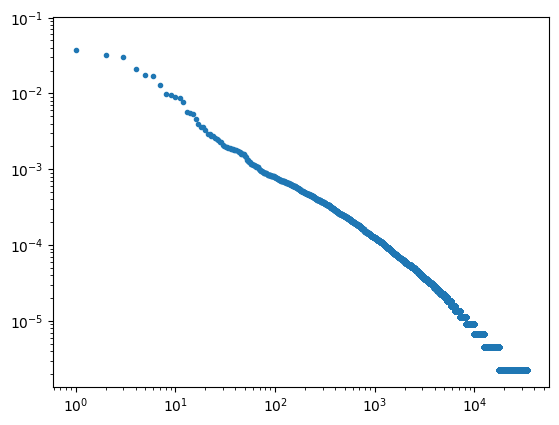

In [25]:
token_counts = sklearn_regex_tokens
total_tokens = sum(token_counts.values())
freqs = [count / total_tokens for count in token_counts.values()]
freqs.sort(reverse=True)

plt.plot(freqs, '.')
plt.yscale('log')
plt.xscale('log')

### Part 3: Train and Evaluate Classifiers

Now let's build our nationality classifier.

For later use, we'll store the train/dev/test labels:

In [26]:
y_train = list(train_df.nationality)
y_dev = list(dev_df.nationality)
y_test = list(test_df.nationality)

#### Task 3.1: Generate tf-idf Reweighted Bag-of-Words Features

We will use `TfidfVectorizer` to convert each biography into features:

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

MIN_DF = 500
vectorizer = TfidfVectorizer(min_df=MIN_DF, stop_words='english')
X_train = vectorizer.fit_transform(train_df.bio)

print('size:', X_train.shape)
print('vocab:', vectorizer.get_feature_names_out())

size: (41544, 2760)
vocab: ['000' '08' '10' ... 'younger' 'youngest' 'youth']


In [28]:
# Technical note on the efficiency of sparse matrices

print("here's how many values we'd need to store if we represented X_train as a regular matrix")
print(X_train.shape[0] * X_train.shape[1])
print()
print("here's how many values we'd need to store if we represented X_train as a sparse matrix")
print(len(X_train.nonzero()[0]))
print("(with a bit of overhead for the sparse matrix data structure...don't worry about that though)")
print("note this number is much smaller")

here's how many values we'd need to store if we represented X_train as a regular matrix
114661440

here's how many values we'd need to store if we represented X_train as a sparse matrix
4446231
(with a bit of overhead for the sparse matrix data structure...don't worry about that though)
note this number is much smaller


#### Task 3.2: Featurize Dev Data

Generate the feature representations for the dev data:

In [29]:
X_dev = vectorizer.transform(dev_df.bio)
print(X_dev.shape)

(5193, 2760)


#### Task 3.3: Train Classifier

We'll train a logistic regression classifier:

In [30]:
clf = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)

print('labels:', clf.classes_)
print(clf.intercept_)
print(clf.coef_)

labels: ['american' 'australian' 'british' 'canadian' 'dutch' 'english' 'french'
 'german' 'indian' 'irish' 'italian' 'japanese' 'polish' 'russian'
 'scottish' 'spanish' 'swedish' 'united states' 'usa']
[ 2.22073050e+00  5.15944030e-03  1.19515537e+00  3.92135258e-01
 -6.07323098e-01  1.37914851e-01  2.50274182e-01  4.13356521e-01
  3.28027870e-03 -6.73019251e-01  1.70035109e-01  2.55696964e-01
 -6.42371791e-01 -6.37337599e-01 -9.24116959e-01 -7.38201579e-01
 -1.01579603e+00  1.95242003e-01 -8.14172270e-04]
[[ 0.51831624  0.48983971  0.01763015 ... -1.08613593  0.86943763
  -0.95471664]
 [-0.49198796  0.14285793  0.0119578  ...  0.37033106  0.42430046
  -0.29727666]
 [-0.29855997 -0.29331996 -0.43682531 ...  0.64282674 -0.3862552
  -0.33945403]
 ...
 [ 0.08597679 -0.06127994 -0.54019456 ...  0.18363478  0.18868065
   0.07423576]
 [-0.88162002 -0.13396451 -0.76672667 ... -0.32053637 -0.04802813
   0.07207946]
 [-0.35402691  0.08291797 -0.14750084 ...  0.18996126 -0.38702549
   0.1701677

C:\Python\Python_39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Task 3.4: Train Baseline Classifiers

Implement two baseline classifiers using `DummyClassifier`:

In [31]:
from sklearn.dummy import DummyClassifier

uniform_clf = DummyClassifier(strategy='uniform', random_state=RANDOM_SEED).fit(X_train, y_train)
stratified_clf = DummyClassifier(strategy='stratified', random_state=RANDOM_SEED).fit(X_train, y_train)

print(uniform_clf.predict(X_dev[:25]))
print(stratified_clf.predict(X_dev[:25]))

['german' 'united states' 'irish' 'russian' 'irish' 'french' 'russian'
 'japanese' 'canadian' 'american' 'japanese' 'indian' 'indian' 'russian'
 'usa' 'irish' 'french' 'russian' 'united states' 'swedish' 'english'
 'usa' 'japanese' 'indian' 'italian']
['british' 'british' 'american' 'american' 'dutch' 'german' 'british'
 'american' 'italian' 'indian' 'american' 'german' 'american' 'american'
 'american' 'american' 'italian' 'american' 'british' 'usa' 'american'
 'american' 'american' 'united states' 'american']


#### Task 3.4.1: Interpret Baseline Classifiers

Set `most_freq_guess` and `most_freq_pr`:

In [32]:
most_freq_guess = 'american'
most_freq_pr = 0.37750336992104755
print(most_freq_guess, most_freq_pr)

american 0.37750336992104755


#### Task 3.5: Generate Model Predictions

Generate predictions for the dev data:

In [33]:
lr_dev_preds = clf.predict(X_dev)
uniform_dev_preds = uniform_clf.predict(X_dev)
stratified_dev_preds = stratified_clf.predict(X_dev)

print(lr_dev_preds[:25])

['british' 'british' 'indian' 'american' 'spanish' 'american' 'russian'
 'american' 'irish' 'indian' 'american' 'american' 'american' 'american'
 'american' 'italian' 'american' 'american' 'british' 'american'
 'american' 'american' 'american' 'american' 'american']


#### Task 3.6: Evaluate Model Predictions

Compute macro-averaged F1 scores:

In [34]:
lr_f1 = f1_score(y_true=y_dev, y_pred=lr_dev_preds, average='macro')
uniform_f1 = f1_score(y_true=y_dev, y_pred=uniform_dev_preds, average='macro')
stratified_f1 = f1_score(y_true=y_dev, y_pred=stratified_dev_preds, average='macro')

print('logistic regression f1:', lr_f1)
print('uniform random guessing f1:', uniform_f1)
print('stratified random guessing f1:', stratified_f1)

logistic regression f1: 0.7617058014979912
uniform random guessing f1: 0.04107889723595883
stratified random guessing f1: 0.0516538950424169


#### Task 3.6.1: Compare Macro- with Micro-Averaging

Compute micro-averaged F1 scores:

In [35]:
lr_f1_micro = f1_score(y_true=y_dev, y_pred=lr_dev_preds, average='micro')
uniform_f1_micro = f1_score(y_true=y_dev, y_pred=uniform_dev_preds, average='micro')
stratified_f1_micro = f1_score(y_true=y_dev, y_pred=stratified_dev_preds, average='micro')

print('microaveraged logistic regression f1:', lr_f1_micro)
print('microaveraged uniform random guessing f1:', uniform_f1_micro)
print('microaveraged stratified random guessing f1:', stratified_f1_micro)

microaveraged logistic regression f1: 0.8178316965145388
microaveraged uniform random guessing f1: 0.052378201424995184
microaveraged stratified random guessing f1: 0.18024263431542462


### Part 4: Examine Classifier Performance

Let's examine how the model uses the input features to come up with output labels and dig deeper into its performance.

#### Task 4.1: Examine Model Weights for Each Feature

The feature weights learned by our logistic regression model roughly correspond to how informative each feature (i.e., word) is of each class (i.e., nationality label).

In [36]:
coefs = clf.coef_
features = vectorizer.get_feature_names_out()
classes = clf.classes_

coef_df = pd.DataFrame(data=coefs.T, index=features, columns=classes)
display(coef_df)

print('most predictive words for american:')
print(coef_df['american'].sort_values(ascending=False).head(10))
print()
print('most predictive words for canadian:')
print(coef_df['canadian'].sort_values(ascending=False).head(10))

,american,australian,british,canadian,dutch,english,french,german,indian,irish,italian,japanese,polish,russian,scottish,spanish,swedish,united states,usa
000,0.518316,-0.491988,-0.298560,0.508228,0.830816,0.484419,-0.123375,0.024988,-0.488016,-0.294453,-0.058393,0.428148,-0.034471,0.028962,0.428171,-0.313123,0.085977,-0.881620,-0.354027
08,0.489840,0.142858,-0.293320,-0.020717,0.072313,0.080704,0.013213,-0.152922,-0.128716,-0.102208,0.334436,-0.137518,0.258943,-0.082907,-0.119552,-0.242121,-0.061280,-0.133965,0.082918
10,0.017630,0.011958,-0.436825,0.571092,-0.292843,0.165266,0.367483,0.386878,0.220128,0.450942,0.093750,0.056323,-0.219796,0.016525,-0.300938,0.346850,-0.540195,-0.766727,-0.147501
100,0.175874,-0.046996,-0.108253,0.086444,-0.021517,-0.283867,-0.293748,-0.091089,0.131450,-0.352610,0.130447,0.715892,0.379453,-0.568856,0.044730,-0.289618,0.073587,-0.374804,0.693479
10th,-0.567834,-0.349525,-0.231237,-0.058473,-0.089720,-0.051205,0.058600,-0.209090,0.250354,0.254891,0.318673,1.029490,-0.054907,0.142473,0.107138,0.083565,-0.123253,-0.412767,-0.097173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yorkshire,-1.861423,-0.431546,3.290356,-0.405314,-0.170139,3.330029,-0.356180,-0.401695,-0.428060,-0.329053,-0.391586,-0.293259,-0.061430,-0.147890,-0.364892,-0.179698,-0.142319,-0.419474,-0.236427
young,0.581853,0.475815,0.256561,-0.079970,0.046781,0.262734,0.053634,-0.820664,-0.116474,0.119175,0.110671,0.529735,-0.312784,-0.250235,-0.326178,-0.362708,0.253684,-0.281497,-0.140133
younger,-1.086136,0.370331,0.642827,-0.450751,0.775442,-0.259635,-0.130428,-0.550581,0.515961,-0.029118,0.532218,0.283839,0.030270,-0.251420,-0.275707,-0.170172,0.183635,-0.320536,0.189961
youngest,0.869438,0.424300,-0.386255,-0.214907,-0.065204,-0.278806,0.067890,-0.143956,0.028181,0.083296,-0.237813,-0.118625,0.024020,-0.134896,0.620876,-0.291166,0.188681,-0.048028,-0.387025


most predictive words for american:
american         10.393522
york              5.606982
california        5.545287
basketball        5.373361
massachusetts     4.296378
washington        4.116202
boston            3.992898
carolina          3.982720
virginia          3.905291
pennsylvania      3.821705
Name: american, dtype: float64

most predictive words for canadian:
canadian      14.664756
canada        11.756757
toronto        8.559274
ontario        8.488917
montreal       7.300527
columbia       5.348872
premier        2.602112
edward         2.432212
prince         2.136717
lieutenant     2.053237
Name: canadian, dtype: float64


#### Task 4.1.1: Find Most Informative Features

Set `top_french_feats` to be a list containing the five words that are most informative of the "french" nationality label:

In [37]:
top_french_feats = coef_df['french'].sort_values(ascending=False).head(5).index.tolist()
print(top_french_feats)

['french', 'paris', 'france', 'jean', 'des']


We can also look at what exactly the model predicts and examine its accuracy, common confusions, and some example errors.

#### Task 4.2: Examine Model Performance per Label

Create dictionaries for class sizes and accuracies:

In [38]:
pred_df = pd.DataFrame({'pred': lr_dev_preds, 'label': y_dev})
pred_df['correct'] = pred_df.label == pred_df.pred

class_size = pred_df['label'].value_counts()
class_accuracy = pred_df[pred_df['correct']].groupby('label').size() / class_size

class_size = class_size.to_dict()
class_accuracy = class_accuracy.fillna(0).to_dict()

pred_stats = pd.DataFrame({'class_accuracy': class_accuracy, 'class_size': class_size})
display(pred_stats.sort_values('class_accuracy', ascending=False))

,class_accuracy,class_size
american,0.974093,1930
polish,0.906542,107
australian,0.896714,213
indian,0.880682,176
british,0.854756,778
french,0.847222,216
german,0.834197,193
canadian,0.789286,280
japanese,0.789062,128
dutch,0.781609,87


Text(0.5, 23.52222222222222, 'prediction')

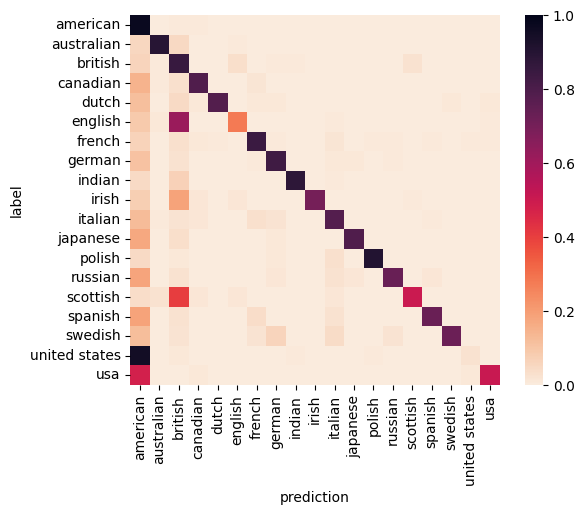

In [39]:
# Examine the confusion matrix

conf_df = pd.DataFrame(data=confusion_matrix(y_dev, lr_dev_preds, labels=classes, normalize='true'),
                      index=classes, columns=classes)

ax = sns.heatmap(conf_df, square=True, cmap=sns.cm.rocket_r, vmin=0, vmax=1)
ax.set_ylabel('label')
ax.set_xlabel('prediction')

#### Task 4.2.1: Examining the Confusion Matrix

Set `top_preds_for_canadian` to the five most frequent predictions for "canadian":

In [40]:
canadian_preds = pred_df[pred_df['label'] == 'canadian']['pred']
prediction_counts = Counter(canadian_preds)
top_preds_for_canadian = [pred for pred, count in prediction_counts.most_common(5)]
print(top_preds_for_canadian)

['canadian', 'american', 'british', 'french', 'australian']


#### Task 4.2.2: Diagnosing Some Confusions

Identify the most accurate class and confused classes:

In [41]:
most_accurate_class = 'american'
confused_classes = ['united states', 'usa']
print(most_accurate_class)
print('redundant labels:', confused_classes)

american
redundant labels: ['united states', 'usa']


#### Task 4.3: Inspect Data Points with Incorrect Predictions

Analyze incorrect predictions where the model is confident or unconfident:

In [42]:
probs = clf.predict_proba(X_dev).max(axis=1)
pred_df['prob'] = probs
pred_df['bio'] = dev_df.bio.values

incorrect_preds = pred_df[~pred_df['correct']]
most_confident_incorrect = incorrect_preds.nlargest(10, 'prob')
least_confident_incorrect = incorrect_preds.nsmallest(10, 'prob')

print('most confident incorrect predictions')
display(most_confident_incorrect)
print()
print('least confident incorrect predictions')
display(least_confident_incorrect)

most confident incorrect predictions


,pred,label,correct,prob,bio
5100,italian,french,False,0.999862,Early life\nMilza was a second-generation Ital...
654,swedish,dutch,False,0.999020,"Biography\nDe Geer was born in Liège, Belgium..."
4179,irish,canadian,False,0.998145,"Career\nNí Chofaigh is a journalist, presenter..."
4049,canadian,british,False,0.993532,John Roger Spottiswoode (born 5 January 1945) ...
3692,canadian,american,False,0.992715,"Early life\nBeard was born in Scarborough, Ont..."
4266,canadian,irish,False,0.989996,"Early years\nBorn in Mooncoin, Co. Kilkenny, I..."
3369,american,french,False,0.987551,Early life and college years\nOlivier Saint-Je...
1161,american,united states,False,0.985592,Biography\nHughes joined the Army after high s...
127,canadian,italian,False,0.984926,Early life\nCaruana was born into the mob in C...
2197,polish,american,False,0.983407,"Life and career\nSchally was born in Wilno, Se..."



least confident incorrect predictions


,pred,label,correct,prob,bio
4480,german,italian,False,0.114869,"Life\nBorn in Milano, Merz started drawing dur..."
754,united states,french,False,0.143373,"Last years and death\nIn the meantime, he had ..."
3045,british,japanese,False,0.147103,Biography\nŌta Sukemoto was the third son of H...
1806,american,polish,False,0.147209,Personal bests\nOutdoor\n* 100 metres – 10.76 ...
3057,american,german,False,0.151718,Stefan Lucks is a researcher in the fields of ...
2482,spanish,british,False,0.153724,Career\n===Early career===\nDavies started rac...
3704,british,french,False,0.161031,Biography\nGiscard d'Estaing studied at the P...
1542,american,dutch,False,0.168583,Early life and career\nBorn Georg Henri Anton ...
1832,british,english,False,0.176894,"Life and career\nNina was born in Brasília, Di..."
755,french,spanish,False,0.177196,Career\nLeón travelled to Madrid to start a ca...


In [43]:
# Inspect confident incorrect predictions

for _, row in most_confident_incorrect.iterrows():
    print(f'actual: {row.label}; predicted: {row.pred}; probability estimate: {row.prob:.3f}')
    print('bio:')
    print(row.bio[:500])
    print()

actual: french; predicted: italian; probability estimate: 1.000
bio:
Early life
Milza was a second-generation Italian immigrant, born in Paris, France to Italian parents. His father, Olivier Milza, was born near Parma in Italy. His status as an immigrant motivated his studies in Italian history and Italian-French immigration. Milza first visited Italy at 16, learned Italian and began to study history.


actual: dutch; predicted: swedish; probability estimate: 0.999
bio:
Biography
De Geer was born in  Liège, Belgium. He was the son of the iron industrialist and merchant Louis de Geer de Gaillarmont (1535-1602), and Jeanne de Neille (1557-1641). His father had previously (1563) been married to Maria de Jalhéa (died 1578). In 1592, one of De Geer's half-sisters, Marie de Geer (1574-1609) married  (1569-1636), a Dutch merchant and a director of the Dutch East India Company who lived in Dordrecht. Presumably due to ongoing turmoil in the Prince-Bishopric of Liège as

actual: canadian; predi